Variables (input and output) drawn from [Cloete and Mbati](http://www.cepd.org.za/files/HESummit_Commission4_Differentiation.pdf).

Input variables:
* %’s headcount enrolment in SET
* M&D headcount enrolments
* student: academic staff FTE ratios
* permanent staff with doctoral degrees
* private income 
* government student fee income per student

Output variables:
* success rate
* graduation rate
* weighted research output by permanent staff member

Data from [CHET's SA Higher Education Performance Data](http://www.chet.org.za/data/sahe-open-data)

In [274]:
import pandas
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.cluster import KMeans
import numpy as np
from scipy.spatial.distance import cdist
import requests
import zipfile
import holoviews as hv
from bokeh.palettes import colorblind

In [275]:
%matplotlib inline

In [276]:
data_directory = '../data'

In [277]:
# fetch the CHET data file
zipped_CHET_file = 'SA_HE_2015_Data.zip'
zipped_CHET_data_url = 'http://www.chet.org.za/files/uploads/data/2017/' + zipped_CHET_file
r = requests.get(zipped_CHET_data_url)
with open(data_directory + '/' + zipped_CHET_file, 'wb') as output:
    output.write(r.content)
zip_ref = zipfile.ZipFile(data_directory + '/' + zipped_CHET_file, 'r')
zip_ref.extractall(data_directory)
zip_ref.close()

In [278]:
enrollment_spreadsheet = data_directory + '/Table 4 Enrolments by CESM and Major Field of Study 2015.xlsx'

In [279]:
data = pandas.read_excel(enrollment_spreadsheet, skiprows=35,
                         index_col=0)
data = data[1:]

### Table 1. Overall enrollment in Higher Education in SA, 2015

In [280]:
data

,Undergraduate,PG < Masters,Masters,Doctorate,TOTAL
Major Field of Study,,,,,
Natural sciences,117401.668,7626.000,9846.166,5683.666,140557.500
Engineering and technology,83967.916,2498.416,6737.250,1695.500,94899.082
Health sciences,43577.583,4569.500,9178.667,2152.000,59477.750
"Business, economic and management sciences",236557.334,23538.334,11592.417,2140.000,273828.085
Education,134434.751,30529.834,3427.083,2158.000,170549.668
Humanities and social sciences,209710.750,15740.915,14764.418,5683.833,245899.916
Unknown,0.000,0.000,0.000,0.000,0.000
Total,825650.002,84502.999,55546.001,19512.999,985212.001


In [281]:
# total enrollment in SET subjects
sum(data.loc[['Natural sciences', 'Engineering and technology', 'Health sciences'],'TOTAL'])

294934.332

In [282]:
def get_SET_md_enrollment(filename, sheet_name):
    data = pandas.read_excel(filename, sheet_name=sheet_name, header=None)
    institution_name = data.iloc[0,0]
    rows_to_skip = data[data[0] == 'Major Field of Study'].index[0]
    data = pandas.read_excel(filename, sheet_name=sheet_name, skiprows=rows_to_skip, index_col=0)
    data.drop(data.index[0])
    SET_enrollment = sum(data.loc[['Natural sciences', 'Engineering and technology', 'Health sciences'],'TOTAL'])
    total_enrollment = data.loc['Total', 'TOTAL']
    m_and_d_enrollment = int(data.loc[['Total'], ['Masters ', 'Doctorate']].sum(axis=1))
    return institution_name, { 'SET percentage': SET_enrollment / total_enrollment, 
                                'M and D enrollment': m_and_d_enrollment }
    

In [283]:
book = pandas.ExcelFile(enrollment_spreadsheet)
enroll_dict = dict()
for sheet_name in book.sheet_names[1:]:
    enroll = get_SET_md_enrollment(enrollment_spreadsheet, sheet_name)
    uni_name_code = enroll[0]
    uni_code = uni_name_code.split()[0]
    uni_name = uni_name_code.split(' - ', maxsplit=1)[1].strip()
    enroll_stats = enroll[1]
    enroll_stats['University Name'] = uni_name
    enroll_dict[uni_code] = enroll_stats
overall_data = pandas.DataFrame.from_dict(enroll_dict, orient='index')

In [284]:
headcount_spreadsheet = data_directory + '/Table 1 Student Headcounts and FTEs.xlsx'

In [285]:
student_to_staff_ratio_spreadsheet = data_directory + '/Table 17 Ratio of Student FTEs to Staff FTEs.xlsx'

In [286]:
data = pandas.read_excel(student_to_staff_ratio_spreadsheet, skiprows=7, index_col=0)
data = data.iloc[1:-1]
data.index = data.index.str.strip()
student_to_staff_2015 = data[2015]
student_to_staff_2015.name = 'Student To Staff Ratio'
overall_data = pandas.concat([overall_data, student_to_staff_2015],axis=1)

In [289]:
staff_qualifications_spreadsheed = data_directory + '/Table 13 Staff Qualifications.xlsx'

In [290]:
column_names = ['University', 'University Name', 'Doctors', 'Masters', 'Other',
       'Total', 'Doctors.1', 'Masters.1', 'Other.1', 'Total.1', 'Doctors.2',
       'Masters.2', 'Other.2', 'Total.2', 'Doctors.3', 'Masters.3', 'Other.3',
       'Total.3', 'Doctors.4', 'Masters.4', 'Other.4', 'Total.4', 'Doctors.5',
       'Masters.5', 'Other.5', 'Total.5', 'Doctors.6', 'Masters.6', 'Other.6',
       'Total.6']

In [291]:
data = pandas.read_excel(staff_qualifications_spreadsheed, skiprows=8, index_col=0, names=column_names)
data = data[:-1]
data.index = data.index.str.strip()
staff_with_phd_2015 = data.loc[:,['Doctors.6', 'Total.6']]
staff_with_phd_2015.columns = ['Staff with PhD', 'Total Academic Staff']
overall_data = pandas.concat([overall_data, staff_with_phd_2015], axis=1)

In [292]:
income_source_spreadsheet = data_directory + '/Table 22 Sources of Income.xlsx'

In [293]:
data = pandas.read_excel(income_source_spreadsheet, skiprows=8, index_col=0)
data.index = data.index.str.strip()
data = data[:-1]
private_income_percentage = data['Private income.6']
private_income_percentage.name = 'Private income %'
overall_data = pandas.concat([overall_data, private_income_percentage], axis=1)

In [294]:
fee_income_per_fte_spreadsheed = data_directory + '/Table 26 Formal Tution Fee Income per FTE.xlsx'

In [295]:
data = pandas.read_excel(fee_income_per_fte_spreadsheed, skiprows=7, index_col=0)
data.index = data.index.str.strip()
data = data[1:-1]
tuition_and_fee_income_per_fte_2015 = data[2015]
tuition_and_fee_income_per_fte_2015.name = 'Tuition and Fee Income Per FTE Student'
overall_data = pandas.concat([overall_data, tuition_and_fee_income_per_fte_2015], axis=1)

Having collected all the data for the input variables I drop the data for SPU, UMP and SMHSU. These universities were founded in 2014, 2014 and 2015 respectively, and data for them is incomplete.

In [296]:
# these are the codoes for the 3 institutions where we lack decent output variables
institutions_to_drop = ['H23', 'H24', 'H26']
overall_data = overall_data.drop(institutions_to_drop)
overall_data = overall_data.drop('Total Academic Staff', axis=1)

In [297]:
abbreviations = [name.split(' - ')[0] if name != 'University of Pretoria' else 'UP' for name in 
                overall_data['University Name']]
overall_data['Abbreviation'] = abbreviations

Next step: add the output variables.

In [300]:
success_rate_spreadsheet = data_directory + '/Table 7 Success Rates.xlsx'

In [301]:
data = pandas.read_excel(success_rate_spreadsheet, skiprows=7, index_col=0)
data = data[1:-1]
data.index = data.index.str.strip()
data = data.drop(institutions_to_drop)

In [302]:
overall_data["Success Rate"] = data[2015]

In [303]:
graduate_rate_spreadsheet = data_directory + '/graduation_data.csv'

#### A note on graduation rates

The CHET data didn't include graduation rates, only number of graduates. The graduation rate is a crude statistic, it only measures how many graduations there are as a proportion of total students enrolled. As the [2015 DHET annual report](http://www.dhet.gov.za/DHET%20Statistics%20Publication/Statistics%20on%20Post-School%20Education%20and%20Training%20in%20South%20Africa%202015.pdf) notes, if the number of students enrolled is growing, it will push down the apparent graduation rate. So these are not great measures of throughput or dropout rate. More discussion on graduation rates is in the CHE's [Education Monitor #9](http://www.che.ac.za/sites/default/files/publications/Higher_Education_Monitor_9.pdf).

One of the problems with graduation rate is that it is calculated by comparing the number of graduates in the year to the same year's enrollment. If year on year enrollment increases it artificially deflates the graduation rate. And if year on year enrollment decreases it artificially inflates that rate. The CHET data *Table 2* shows that UNIVEN grew between 2011 and 2015, and WSU shrank.

Still, to reproduce the DHET calculation, the next section computes the crude graduation rate, differentiating between undergraduate and postgrad rates.

In [304]:
graduation_numbers_spreadsheet = data_directory + '/Table 8 Graduates by Qualification Type.xlsx'
enrollment_numbers_spreadsheet = data_directory + '/Table 3 Enrolment by Qualification Type.xlsx'

In [305]:
graduation_data = pandas.read_excel(graduation_numbers_spreadsheet, skiprows=194, index_col=0)
graduation_data = graduation_data[1:-1]
graduation_data.index = graduation_data.index.str.strip()
graduation_data = graduation_data.drop(institutions_to_drop)
graduation_data_columns_to_keep = ['Total undergraduate (UG)', 'Total postgraduate (PG)', 'Total']
graduation_data = graduation_data.loc[:, graduation_data_columns_to_keep]

In [306]:
enrollment_data = pandas.read_excel(enrollment_numbers_spreadsheet, skiprows=194, index_col=0)
enrollment_data =  enrollment_data[1:-1]
enrollment_data.index = enrollment_data.index.str.strip()
enrollment_data = enrollment_data.drop(institutions_to_drop)
enrollment_data_columns_to_keep = ['Total Undergraduate (UG)', 'Total Postgraduate (PG)', 'Total']
enrollment_data = enrollment_data.loc[:, enrollment_data_columns_to_keep]
enrollment_data.columns = graduation_data_columns_to_keep

In [307]:
crude_graduation_rate = graduation_data.div(enrollment_data)
postgraduate_percentage = enrollment_data['Total postgraduate (PG)'] / (
    enrollment_data['Total postgraduate (PG)'] + enrollment_data['Total undergraduate (UG)'])
crude_graduation_rate.columns = ['Undergraduate Graduation Rate %', 'Postgraduate Graduation Rate %',
                                'Total Graduation Rate %']
crude_graduation_rate['Percentage Postgraduate'] = postgraduate_percentage
overall_data['Percentage Postgraduate'] = postgraduate_percentage
crude_graduation_rate = pandas.concat([overall_data['University Name'], crude_graduation_rate], axis=1)

#### Graduation rates (continued)

I got distracted with another question - what is the proportion of postgrads to undergrads at the universities. I'll keep that column for later use. Anyway that's enough on almost-DHET-style postgrad, undergrad and total graduation rates.

The calculation above is crude, so I decided to chase another figure, one for which the data is easier to access: what is the percentage when you compare the number of students who were enrolled for a 3 year degree or diploma in 2013 graduated in 2015? I know many students in South Africa take more than 3 years to graduate. In fact many are enrolled in 4 year "extended curriculum" programmes. Still, for those who did enroll for a 3 year course, it is instructive to see how many graduates there were 3 years later. Not perfect, but instructive.

In [308]:
enrollment_data_2013 = pandas.read_excel(enrollment_numbers_spreadsheet, skiprows=132, index_col=0)
enrollment_data_2013 = enrollment_data_2013[1:27]
enrollment_data_2013.index = enrollment_data_2013.index.str.strip()
enrollment_data_2013 = enrollment_data_2013.drop(institutions_to_drop)
enrollment_data_2013_columns_to_keep = ['UG Dipl/Cert (3yrs)', '1st B Degree (3yrs)']
enrollment_data_2013.columns
enrollment_data_2013 = enrollment_data_2013.loc[:, enrollment_data_2013_columns_to_keep].fillna(0)
enrollment_data_2013["3 year UG enrollment"] = enrollment_data_2013.iloc[:,0] + enrollment_data_2013.iloc[:,1]

In [309]:
graduation_data_3yrUG = pandas.read_excel(graduation_numbers_spreadsheet, skiprows=194, index_col=0)
graduation_data_3yrUG = graduation_data_3yrUG[1:-1]
graduation_data_3yrUG.index = graduation_data_3yrUG.index.str.strip()
graduation_data_3yrUG = graduation_data_3yrUG.drop(institutions_to_drop)
graduation_data_3yrUG = graduation_data_3yrUG.loc[:, enrollment_data_2013_columns_to_keep].fillna(0)
graduation_data_3yrUG["3 year UG graduation"] = graduation_data_3yrUG.iloc[:,0] + graduation_data_3yrUG.iloc[:,1]

In [310]:
three_year_graduation_rate = pandas.concat([graduation_data_3yrUG['3 year UG graduation'].div(
    enrollment_data_2013['3 year UG enrollment']), overall_data['University Name']], axis=1)
three_year_graduation_rate.columns = ['3 year course graduation rate', 'University Name']
overall_data['3yr Graduation Rate'] = three_year_graduation_rate['3 year course graduation rate']
three_year_graduation_rate

,3 year course graduation rate,University Name
Institution Number,,
H01,0.198490,CPUT - Cape Peninsula University of Technology
H02,0.272181,UCT - University of Cape Town
H03,0.190476,CUT - Central University of Technology
H04,0.200301,DUT - Durban University of Technology
H05,0.189307,FH - University of Fort Hare
H06,0.176636,FS - University of Free State
H07,0.219889,UJ - University of Johannesburg
H08,0.180761,KZN - University of Kwazulu-Natal
H09,0.191313,UL - University of Limpopo


Working on this graduation data has been the least satisfying part of this data analysis, because it is so imprecise. Besides the limitations discussed above, one of the things to note is that distance programmes have a much higher non-completion rate than contact programmes. The DHET sets its undergraduate graduation rate target for 25% for contact programmes and 15% for distance programmes. Even with that in mind, UNISA's about 8% graduation rate is poor. And only a handful of institutions achieve the 25% target set by the DHET for contact programmes.

In [311]:
research_outputs_per_academic_spreadsheet = data_directory + '/Table 19 Weighted Total Research Output per Permanent Academic Staff.xlsx'

In [312]:
data = pandas.read_excel(research_outputs_per_academic_spreadsheet, skiprows=7, index_col=0)
data = data[1:-1]
data.index = data.index.str.strip()
data.drop('H26')
research_outputs_data = data[2015]
overall_data['WRO per Academic'] = research_outputs_data

### Principal Components Analysis and K-means clustering

Ok that is all 9 variables from the Cloete and Mbati presentation included (plus a little more). In that presentation they group universities into three groups, red, green and blue. Firstly I want to know if the data supports that grouping. To that end I'm going to use two tools, principal component analysis and k-means clustering.

[Principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA) statistical technique to make data easier to visualise and interpret. The data we have thus far is 9 variables for each of 23 higher education institutions. I want to get a picture in 2 dimensions, so I use PCA to combine the variables into 2 principal components of variance.

Secondly, I want to assign each of the universities to one of a number of classes. To this end, I use another statistical tool, [k-means clustering](https://en.wikipedia.org/wiki/K-means_clustering). I choose some number, $k$, and then try and find this number of clusters in the data. In the plot below I've combined chosen $k = 4$ and coloured each resulting group. I've also added crosses for the "centroids". These are the "centers" of each cluster.

In [313]:
columns_to_exclude = ['University Name', 'Abbreviation', 'M and D enrollment']
plotting_data = overall_data.drop(columns_to_exclude, axis=1)

plotting_data_std = StandardScaler().fit_transform(plotting_data)
sklearn_pca = sklearnPCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(plotting_data_std)
pca_data = pandas.DataFrame(Y_sklearn, index=overall_data.index, columns=('PCA1', 'PCA2'))


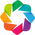

In [314]:
hv.extension('bokeh')

In [316]:
%%opts Scatter [height=600 width=600] (size=8)
%%opts Points (marker='x' size=15)
%%opts Table [height=600]
%%opts Overlay [legend_limit=30]

model = KMeans(n_clusters=4).fit(pca_data)
df_with_kmeans = pca_data.copy()
df_with_kmeans['group'] = model.labels_
df_with_kmeans['name'] = overall_data['University Name']
df_with_kmeans['abbreviation'] = overall_data['Abbreviation']

extra_extent_x = 1
extra_extent_y = 0.15
max_x = df_with_kmeans['PCA1'].max()
max_x += extra_extent_x
min_x = df_with_kmeans['PCA1'].min()
min_x -= extra_extent_x
max_y = df_with_kmeans['PCA2'].max()
max_y += extra_extent_y
min_y = df_with_kmeans['PCA2'].min()
min_y -= extra_extent_y

palette = [hv.Cycle('Colorblind').values[i] for i in (7,3,4,6)]
scatters = []
print(df_with_kmeans['group'].max())
for i in range(df_with_kmeans['group'].max() + 1):
    data = df_with_kmeans[df_with_kmeans['group'] == i]
    scatters.append(hv.Scatter(data,
                               vdims=['PCA2'], 
                               label='Group {}'.format(i+1),
                               extents=(min_x, min_y, max_x, max_y)).opts(style=dict(color=palette[i])))
scatter = hv.Overlay(scatters)

points = hv.Points(model.cluster_centers_, label='centroids').opts(
    style=dict(color=hv.Cycle('Colorblind').values[5]))
offset_x = (scatter.range('PCA1')[1] - scatter.range('PCA1')[0]) * 0.05
offset_y = 2

plot = scatter * points
texts = []
for i, label in enumerate(overall_data.index):
    x = df_with_kmeans['PCA1'][i] + offset_x
    y = df_with_kmeans['PCA2'][i]
    plot *= hv.Text(x, y, df_with_kmeans['abbreviation'][i])

plot

3


:Overlay
   .Scatter.Group_1  :Scatter   [PCA1]   (PCA2)
   .Scatter.Group_2  :Scatter   [PCA1]   (PCA2)
   .Scatter.Group_3  :Scatter   [PCA1]   (PCA2)
   .Scatter.Group_4  :Scatter   [PCA1]   (PCA2)
   .Points.Centroids :Points   [x,y]
   .Text.I           :Text   [x,y]
   .Text.II          :Text   [x,y]
   .Text.III         :Text   [x,y]
   .Text.IV          :Text   [x,y]
   .Text.V           :Text   [x,y]
   .Text.VI          :Text   [x,y]
   .Text.VII         :Text   [x,y]
   .Text.VIII        :Text   [x,y]
   .Text.IX          :Text   [x,y]
   .Text.X           :Text   [x,y]
   .Text.XI          :Text   [x,y]
   .Text.XII         :Text   [x,y]
   .Text.XIII        :Text   [x,y]
   .Text.XIV         :Text   [x,y]
   .Text.XV          :Text   [x,y]
   .Text.XVI         :Text   [x,y]
   .Text.XVII        :Text   [x,y]
   .Text.XVIII       :Text   [x,y]
   .Text.XIX         :Text   [x,y]
   .Text.XX          :Text   [x,y]
   .Text.XXI         :Text   [x,y]
   .Text.XXII        :Text   [x,y]
   .Text.XXIII       :Text   [x,y]

The PCA shows us some kind of clustering, but it doesn't show what variables have been summarised into the principal components. The 4 groups are as follows:

1. UP, UCT, SU, WITS and RU.
2. UJ, NWU, NMU, UKZN, UWC, FH and FS
3. CPUT, TUT, VUT, MUT, DUT, CUT, UL, WSU, UZ and UNIVEN
4. UNISA

The first group corresponds with the "red" group in Cloete & Mbali's presentation. They also correspond closely with the upper band in Cooper's paper - the only difference being that Cooper includes UKZN, not RU and moves RU to the second band. 

The second group corresponds fairly closely with Cooper's middle band. UNISA and RU are here in Cooper's classification, whereas in my PCA UNISA is in its own group and RU is in group 1. There is some correspondence as well with Cloete & Mbali's "green" group, but they include UL and UZ, which end up in group 3 in the PCA.

The third group is contains the universities of technology along with UL, WSU, UZ and UNIVEN.

How well does this grouping fit the data? One way to answer that is to count the sum of distances between the group centroids and the group members. Doing this for various values of $k$ gives what is called an elbow plot, included below. 

In [339]:
def elbow_plot(dataframe, k_values):
    distortions = []
    k_values = list(range(2,20))
    for k in k_values:
        model = KMeans(n_clusters=k).fit(dataframe)
        model.labels_
        distortion = sum(np.min(cdist(dataframe, 
                                      model.cluster_centers_, 'euclidean'), axis=1)) / dataframe.shape[0]
        distortions.append(distortion)
    plt.plot(k_values, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.xticks(range(2,21))

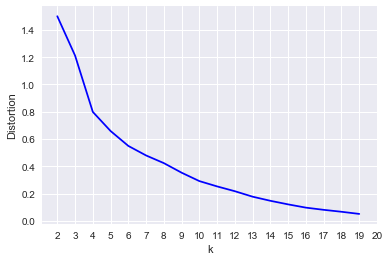

In [340]:
elbow_plot(pca_data, list(range(2,20)))

The thing to look for in a elbow plot is a "kink", i.e. a point at which the rate at which the distortion is changes distinctly. There is a small kink at 4, so $k=4$ is a reasonably choice. Of course within the grouping there are differences. Below is an example of a plot with $k=6$. Is this a better classification than the $k=4$ one? To understand that we need to look into the reasons behind the classification

In [342]:
%%opts Scatter [height=600 width=600] (size=8)
%%opts Points (marker='x' size=15)
%%opts Table [height=600]
%%opts Overlay [legend_limit=30]

model = KMeans(n_clusters=6).fit(pca_data)
df_with_kmeans = pca_data.copy()
df_with_kmeans['group'] = model.labels_
df_with_kmeans['name'] = overall_data['University Name']
df_with_kmeans['abbreviation'] = overall_data['Abbreviation']

extra_extent_x = 1
extra_extent_y = 0.15
max_x = df_with_kmeans['PCA1'].max()
max_x += extra_extent_x
min_x = df_with_kmeans['PCA1'].min()
min_x -= extra_extent_x
max_y = df_with_kmeans['PCA2'].max()
max_y += extra_extent_y
min_y = df_with_kmeans['PCA2'].min()
min_y -= extra_extent_y

palette = [hv.Cycle('Colorblind').values[i] for i in (7,3,4,6,2,4)]
scatters = []
print(df_with_kmeans['group'].max())
for i in range(df_with_kmeans['group'].max() + 1):
    data = df_with_kmeans[df_with_kmeans['group'] == i]
    scatters.append(hv.Scatter(data,
                               vdims=['PCA2'], 
                               label='Group {}'.format(i+1),
                               extents=(min_x, min_y, max_x, max_y)).opts(style=dict(color=palette[i])))
scatter = hv.Overlay(scatters)

points = hv.Points(model.cluster_centers_, label='centroids').opts(
    style=dict(color=hv.Cycle('Colorblind').values[5]))
offset_x = (scatter.range('PCA1')[1] - scatter.range('PCA1')[0]) * 0.05
offset_y = 2

plot = scatter * points
texts = []
for i, label in enumerate(overall_data.index):
    x = df_with_kmeans['PCA1'][i] + offset_x
    y = df_with_kmeans['PCA2'][i]
    plot *= hv.Text(x, y, df_with_kmeans['abbreviation'][i])

plot

5


:Overlay
   .Scatter.Group_1  :Scatter   [PCA1]   (PCA2)
   .Scatter.Group_2  :Scatter   [PCA1]   (PCA2)
   .Scatter.Group_3  :Scatter   [PCA1]   (PCA2)
   .Scatter.Group_4  :Scatter   [PCA1]   (PCA2)
   .Scatter.Group_5  :Scatter   [PCA1]   (PCA2)
   .Scatter.Group_6  :Scatter   [PCA1]   (PCA2)
   .Points.Centroids :Points   [x,y]
   .Text.I           :Text   [x,y]
   .Text.II          :Text   [x,y]
   .Text.III         :Text   [x,y]
   .Text.IV          :Text   [x,y]
   .Text.V           :Text   [x,y]
   .Text.VI          :Text   [x,y]
   .Text.VII         :Text   [x,y]
   .Text.VIII        :Text   [x,y]
   .Text.IX          :Text   [x,y]
   .Text.X           :Text   [x,y]
   .Text.XI          :Text   [x,y]
   .Text.XII         :Text   [x,y]
   .Text.XIII        :Text   [x,y]
   .Text.XIV         :Text   [x,y]
   .Text.XV          :Text   [x,y]
   .Text.XVI         :Text   [x,y]
   .Text.XVII        :Text   [x,y]
   .Text.XVIII       :Text   [x,y]
   .Text.XIX         :Text   [x,y]
   .Text.XX          :Text   [x,y]
   .Text.XXI         :Text   [x,y]
   .Text.XXII        :Text   [x,y]
   .Text.XXIII       :Text   [x,y]

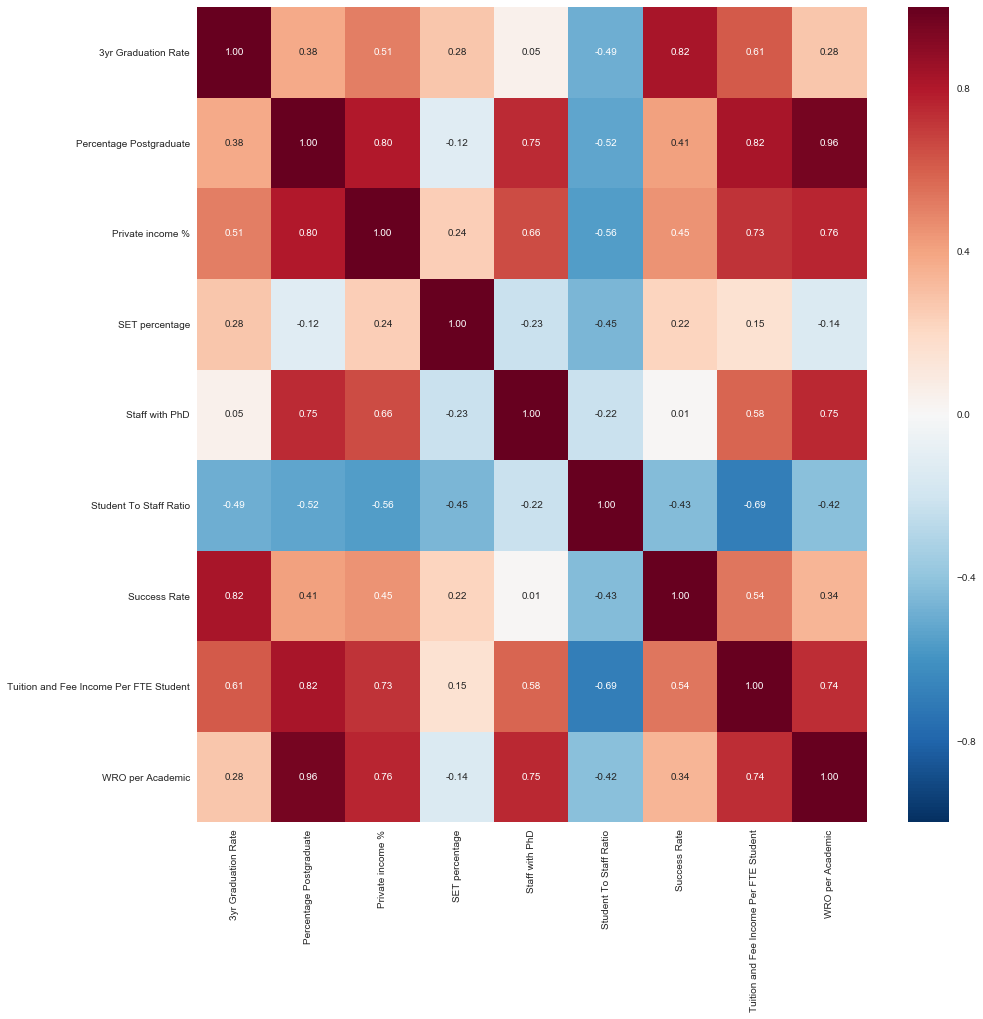

In [317]:
plotting_data = overall_data.loc[:,overall_data.columns.difference(columns_to_exclude)]
plt.figure(figsize=(15, 15))
sns.heatmap(plotting_data.corr(), annot=True, fmt=".2f")


What correlates? Let's look at this from 2 perspectives: firstly the "research university" perspective:

*Weighted Research Output per Academic staff member* strongly correlates with *Percentage Postgraduate*, *Private income %*, *Staff with PhD*, *Tuition Fee Income Per FTE Student*. There is a negative correlation with *Student to Staff Ratio* but it is at -0.42, so not as strong as the positive correlations. This is all evidence for the existence of a well funded "Postgrad and Research System". Interestingly, there is a weak corellation between research  output and *3yr Graduation Rate*, suggesting that undergraduate success is not necessary for research success. This might be evidence of divided universities, where the "Postgrad and Research System" does not entirely rely on the university's own undergraduate teaching mission. Postgrads and skilled staff can be (and are) recruited outside the system.

Secondly, the *undergraduate performance* perspective. Here the year on year *Success Rate* and the *3yr Graduation Rate* are the things to look at. The two measures correlate with each other - not surprisingly, since graduate requires year on year success. For both of these measures there are correlations with *Private income %* and *Tuition Fee Income Per FTE Student* - better resourced universities are more successful at graduating students - the correlation is not especially strong though. There is also an inverse correlation with *Student to Staff Ratio*, again not a terribly strong one though. I'd hazard a guess that there are missing factors, factors that can more strongly explain the undergraduate success story (or lack thereof).

Note that in the above data there is no information on race, class, gender, university location and a host of other socio-economic factors. I'll deal with those later. First a bit more PCA experimentation.

Do you see clusters? Maybe, a bit. I really should plot the centroids of a K-means analysis. But let's move on to an elbow plot for now: there seems to be a kink around 3 now. Leaving aside the fancy stuff, on to some graphs...

In [320]:
hv.help(scatters[0], visualization=False)


To view the visualization options applicable to this object or class, use:

   holoviews.help(obj, visualization=True)

Parameters of 'Scatter' instance

Parameters changed from their default values are marked in red.
Soft bound values are marked in cyan.
C/V= Constant/Variable, RO/RW = ReadOnly/ReadWrite, AN=Allow None

Name                        Value                     Type     Bounds   Mode 

cdims                         {}                      Dict              V RW 
datatype   ['array', 'dataframe', 'dictionary', ...   List   (0, None)  V RW 
extents    (-4.5261331781822687, -2.533674510193...  Tuple              V RW 
group                     'Scatter'                  String             C RW 
kdims                [Dimension('PCA1')]              List     (1, 2)   V RW 
label                     'Group 1'                  String             C RW 
vdims                [Dimension('PCA2')]              List   (1, None)  V RW 

Parameter docstrings:

cdims:    The constant dime

In [321]:
for k in range(4):
    print("Group", k)
    print(overall_data[overall_data.index.isin(df_with_kmeans[df_with_kmeans['group'] == k].index)]['University Name'])

Group 0
H01    CPUT - Cape Peninsula University of Technology
H03           CUT  - Central University of Technology
H04            DUT  - Durban University of Technology
H09                       UL  - University of Limpopo
H16           TUT  - Tshwane University of Technology
H17                      UNIVEN - University of Venda
H18               VUT - Vaal University of Technology
H19                    WSU - Walter Sisulu University
H22                       UZ - University of Zululand
H25         MUT - Mangosuthu University of Technology
Name: University Name, dtype: object
Group 1
H02        UCT  - University of Cape Town
H12                University of Pretoria
H13               RU  - Rhodes University
H15      SU  - University of Stellenbosch
H21    WITS - University of Witwatersrand
Name: University Name, dtype: object
Group 2
H14    UNISA  - University of South Africa
Name: University Name, dtype: object
Group 3
H05           FH  - University of Fort Hare
H06          FS  - U

In [322]:
# based on https://github.com/wu-song/bokeh_based_visualization
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool

_marker_types = [
    "circle",
    "square",
    "triangle",
    "diamond",
    "inverted_triangle",
    "asterisk",
    "cross",
    "x",
    "circle_cross",
    "circle_x",
    "square_x",
    "square_cross",
    "diamond_cross",
]

palette = [
'#7BC65F',
'#6698EC',
'#E6754C',
'#33BEB0',
'#D066F6',
'#F45665',
'#3CFF00',
'#0432FF',
'#C10000',
'#73FDD6',
'#8C00DB',
'#FF0000',
'#FDFF00',
'#EED1D1',
'#FFC000',
'#F938EB',
'#BF9000',
'#AAAAAA',
'#000000']

conversions = {
            "*": "asterisk",
            "+": "cross",
            "o": "circle",
            "ox": "circle_x",
            "o+": "circle_cross"
        }

def scatter_with_hover(df, x, y, color=None, marker=None, size=10, line_color=None,cols=None,
                       title=None, xlabel=None, ylabel=None, legend='top_right',
                       fig=None, plot_width=600, plot_height=600, tools="pan,wheel_zoom,box_zoom,save,reset", **kwargs):
    """
    Plots an interactive scatter plot of `x` vs `y` using bokeh, with automatic
    tooltips showing columns from `df`.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing the data to be plotted
    x : str
        Name of the column to use for the x-axis values
    y : str
        Name of the column to use for the y-axis values
    color : str
        Name of the column to use for color
    marker : str
        Name of marker to use for scatter plot;
        Or, Name of the column to use for marker
    size : int or str
        Size of the marker;
        Or, name of the column to use for size of the marker
    fig : bokeh.plotting.Figure, optional
        Figure on which to plot (if not given then a new figure will be created)
    cols : list of str
        Columns to show in the hover tooltip (default is to show all)
    line_color, title, xlabel, ylabel, legend, tools, ...
        Normal arguments just like 'from bokeh.charts import Scatter'
    **kwargs
        Any further arguments to be passed to fig.scatter

    Returns
    -------
    bokeh.plotting.Figure
        Figure (the same as given, or the newly created figure)

    Example
    -------
    fig = scatter_with_hover(df, 'A', 'B')
    show(fig)

    fig = scatter_with_hover(df, 'A', 'B', cols=['C', 'D', 'E'], marker='x', color='red')
    show(fig)

    fig = scatter_with_hover(df, 'A', 'B', marker='C', color='D', size='E')
    show(fig)

    Author
    ------
    Sam Wu <wusong@live.cn>
    with thanks to Robin Wilson for original code example
    """
    df_temp = df.copy()
    df_temp.insert(0, '__index__', df_temp.index)
    if cols is None:
        # Display *all* columns in the tooltips
        hover = HoverTool(tooltips = [(c, '@' + c) for c in df_temp.columns])
    else:
        # Display just the given columns in the tooltips
        hover = HoverTool(tooltips = [(c, '@' + c) for c in cols])

    if color is None: color = palette[5] #
    if marker is None:
        marker = 'circle'
    elif marker in conversions:
        marker = conversions[marker]

    if color in df_temp.columns:
        color_keys = list(set(df_temp[color]))
        color_dic = dict(zip(palette, color_keys)) # uesed for defining 'color_marker_legend'
        df_temp['__color'] = list(df_temp[color].map(dict(zip(color_keys, palette))))
        df_temp['__color'] = df_temp['__color'].fillna('#000000')
    else:
        df_temp['__color'] = color

    if marker in df_temp.columns:
        marker_keys = list(set(df_temp[marker]))
        marker_dic = dict(zip(_marker_types, marker_keys)) # uesed for defining 'color_marker_legend'
        df_temp['__marker'] = list(df_temp[marker].map(dict(zip(marker_keys, _marker_types))))
        df_temp['__marker'] = df_temp['__marker'].fillna('x')
    else:
        df_temp['__marker'] = marker
    # If we haven't been given a Figure obj then create it with default size.
    if fig is None:
        fig = figure(width=plot_width, height=plot_height, title=title, tools=tools)

    if xlabel is None: xlabel = x
    if ylabel is None: ylabel = y
    fig.xaxis.axis_label = xlabel
    fig.yaxis.axis_label = ylabel

    grouped_df = df_temp.groupby(['__color', '__marker'])
    for color_marker, df_marker in grouped_df:
        #print(marker, df_marker.shape)
        #print(df_marker)
        source = ColumnDataSource(data=df_marker)

        # define legend's format
        if 'color_dic' in dir():
            if 'marker_dic' in dir():
                color_marker_legend = (color_dic[color_marker[0]], marker_dic[color_marker[1]])
            else:
                color_marker_legend = color_dic[color_marker[0]] # 反推‘marker’列的值
        else:
            if 'marker_dic' in dir():
                color_marker_legend = marker_dic[color_marker[1]]
            else:
                color_marker_legend = None

        fig.scatter(x, y, source=source, line_color=line_color, fill_color=color_marker[0], marker=color_marker[1], \
                    size=size, legend=str(color_marker_legend), **kwargs)

    fig.legend.location = legend
    fig.add_tools(hover)
    return fig

I've plotted each variable in the dataset. Some interesting patterns here:

1. The SET (Science, Engineering & Technology) subjects are - not surprisingly - most prominent in the Universities of Technology.
2. David Cooper's 3-class classification based on papers per academic per year still holds up. There are 5 universities with more than 2 papers per academic per year: UP, SU, UCKAR, UKZN, and Wits. FH is nipping on their heels, but watch out - according to [Mouton et al, 2017](http://www.sajs.co.za/extent-south-african-authored-articles-predatory-journals/johann-mouton-astrid-valentine) about a quarter of UFH's research output is being published in what might be pradatory journals. Quite worrying is that of the 10 institutions (MUT, WSU, VUT, CPUT, CUT, TUT, UZ, DUT, UNIVEN and UL) with 1 paper per academic per year or below, 8 also publish 10% of more of their research output in journals that might be predatory (only VUT and TUT miss out this "predatory list").
3. The top 5 "research intensive" universities mostly are also those with lowest student to staff ratios. UP is the exception here, as it is in the lower half of the list.
4. The top graphs are all strongly differentiated. They measure "objectively measurable" things like income, income source, staff to student ratio, staff with PhDs, proportion of students who are postgraduates. Something surprising happens with the last 2 graphs - the 3 year graduation rate, and the "success rate". Even if my calculations on the graduation rate are suspicious, the success rate is an officially recorded number: how many students progress at the end of their academic year. The fact that almost all universities record a 80% or better success rate (the national benchmark is apparently 80%) leaves me wondering what is going on. To be honest, it looks like these figures are being manipulated.

(While I've now added the racial enrollment percentages to these charts, I'm not discussing them here.)

In [323]:
enrollment_race_spreadsheet = data_directory + '/Table 5 Total Enrolments by Race.xlsx'

In [324]:
data = pandas.read_excel(enrollment_race_spreadsheet, skiprows=8, index_col=0, usecols="A,AN:AS")
data = data[1:-1].fillna(0)
data.index = data.index.str.strip()
data = data.drop(institutions_to_drop)
race_ratios = data.iloc[:,:-1].div(data['Total'], axis=0)
race_ratios.columns = [name + ' %' for name in race_ratios.columns]
old_overall_data = overall_data.copy()
overall_data = pandas.concat([overall_data, race_ratios], axis=1)

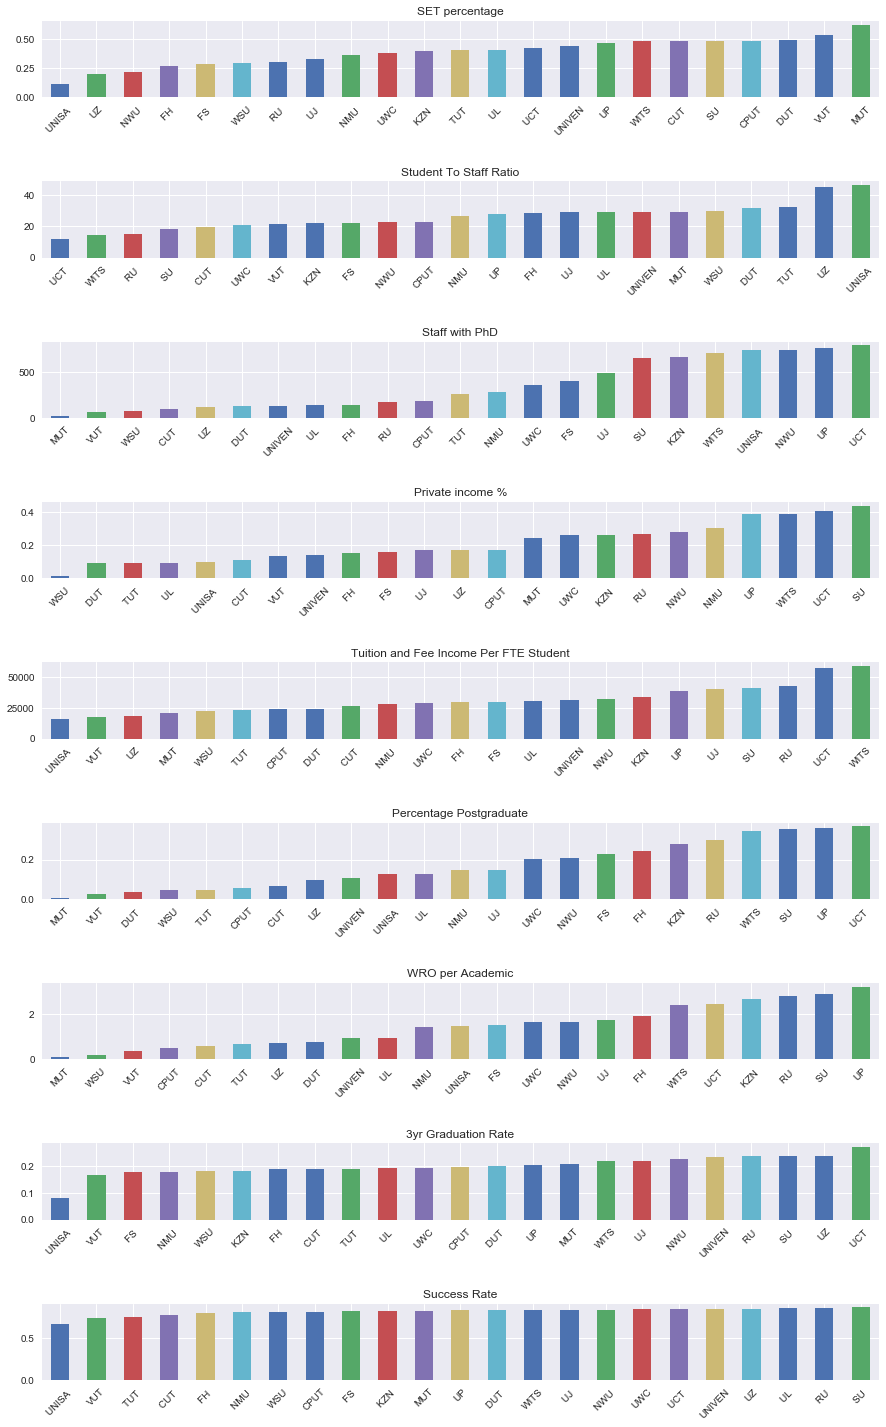

In [325]:
plt.figure(figsize=(15,15))

# columns_to_plot = list(overall_data.columns)
# del columns_to_plot[0]
# del columns_to_plot[1]
columns_to_plot = ['SET percentage',
       'Student To Staff Ratio', 'Staff with PhD', 'Private income %',
       'Tuition and Fee Income Per FTE Student',
       'Percentage Postgraduate', 'WRO per Academic', '3yr Graduation Rate', 'Success Rate']
#         'African  %', 'Coloured %', 'Indian %', 'White %', 'Unknown %']
f, axarr = plt.subplots(len(columns_to_plot), figsize=(15,25))
f.subplots_adjust(hspace=1.1)
for i, column_name in enumerate(columns_to_plot):
    temp_data = overall_data[column_name]
    temp_data.index = [(name.split(' - ')[0] if name != 'University of Pretoria' 
                        else 'UP') for name in list(overall_data['University Name'])]
    temp_data.sort_values().plot(rot=45, kind='bar', ax=axarr[i], title=column_name)
    axarr[i].set_xlabel('')
#     if i < len(columns_to_plot) - 1:
#         axarr[i].tick_params(
#             axis='x',          # changes apply to the x-axis
#             which='both',      # both major and minor ticks are affected
#             bottom='off',      # ticks along the bottom edge are off
#             top='off',         # ticks along the top edge are off
#             labelbottom='off') # labels along the bottom edge are off

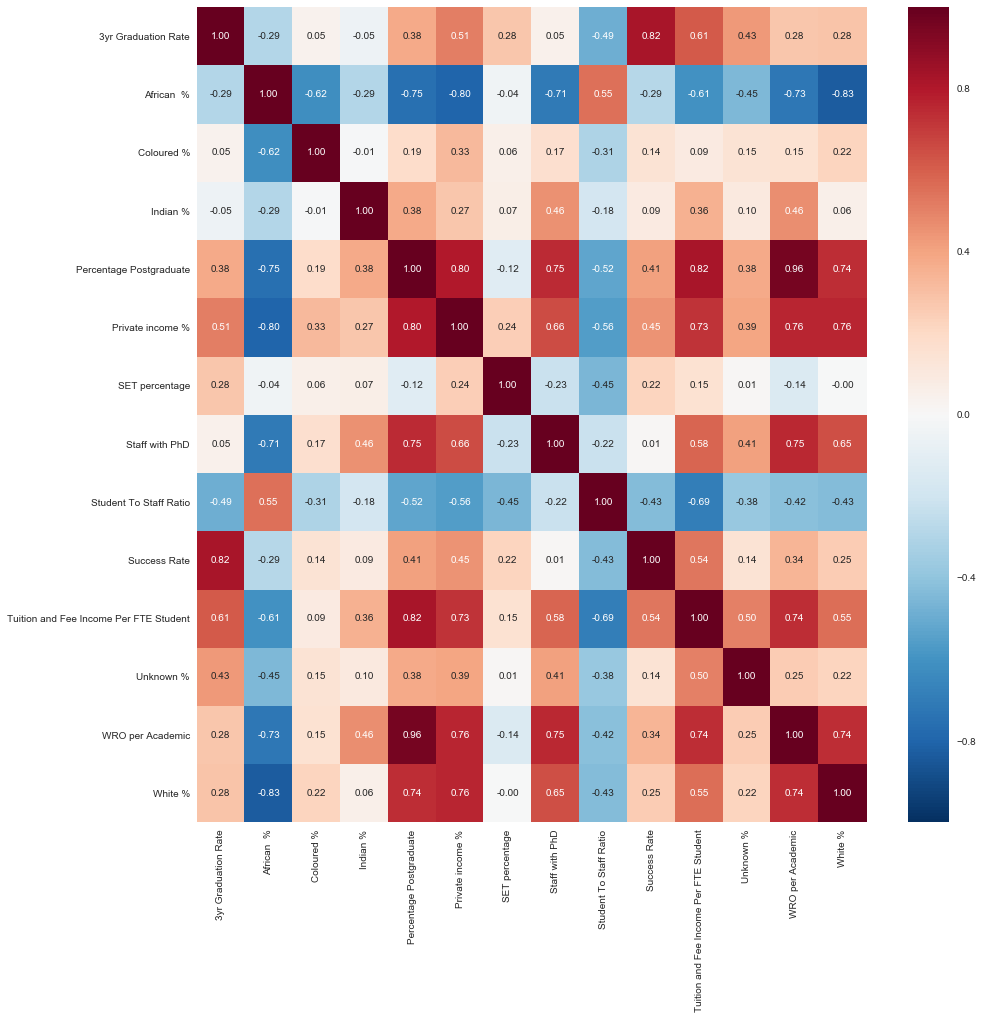

In [326]:
columns_to_exclude.append('M and D enrollment')
plotting_data = overall_data.loc[:,overall_data.columns.difference(columns_to_exclude)]
plt.figure(figsize=(15, 15))
sns.heatmap(plotting_data.corr(), annot=True, fmt=".2f")

Finally added ratios of students by race to the data. What can we see?

1. Of the 4 ratial groups (not counting Unknown), institutions with high percentage of African students have a weak negative correlation with poor undergraduate result markers (*3yr Graduation Rate* and *Success Rate*). Conversely institutons with a high % of white students correlate weakly with good undergraduate result markers. There's no significant correlation for the other 2 ratial groups.
2. A high % of African students at an institution correlates inversely with the presence of students from other racial groups. Mostly strongly when it comes to % of white students, most weakly when it comes to % of Indian students.
3. Higher % of white students correlates positively with what I previously called the "Postgraduate and Research System" markers. Conversely, higher % of African students correlates negatively with these markers.
4. Higher Student to Staff ratio correlates with higher % of African students.

All in all, this is a bleak picture.

In [327]:
# in the graduate rate data we need to drop universities by name, so we reproduce the list of universities
# for which we don't have decent output variable data here
unis_to_exclude = ('Sefako Makgatho Health Science University',  'Sol Plaatje University, Northern Cape', 
                   'University of Mpumalanga')

data = pandas.read_csv(graduate_rate_spreadsheet, names=['University', 'Diploma', 'Degree'], usecols=[0,1,2])
data = data[~data['University'].isin(unis_to_exclude)]
data = data[:-1]
data 

,University,Diploma,Degree
0,Cape Peninsula University of Technology,21,36
1,University of Cape Town,28,21
2,"Central University of Technology, Free State",20,27
3,Durban University of Technology,20,39
4,University of Fort Hare,44,18
5,University of the Free State,22,18
6,University of Johannesburg,20,23
7,University of KwaZulu-Natal,90,17
8,University of Limpopo,n.a.,21
9,Mangosuthu University of Technology,20,51


In [328]:
new_index_list = [] 
graduation_rate_list = []
uni_name_to_code = dict()
for i, row in enumerate(overall_data.loc[:,'University Name']):
    if ' - ' in row:
        uni_name = row.split(' - ')[1]
    else:
        uni_name = row
    code = overall_data.loc[:,'University Name'].index[i]
    uni_name_to_code[uni_name] = code
for i, row in data.iterrows():
    uni_name = row['University']
    if ',' in uni_name:
        uni_name = uni_name.split(',')[0]
    if uni_name == 'University of the Free State':
        uni_name = 'University of Free State'
    if uni_name == 'University of Johannesburg':
        uni_name = 'University of  Johannesburg'
    if uni_name == 'University of KwaZulu-Natal':
        uni_name = 'University of Kwazulu-Natal'
    if uni_name == 'Nelson Mandela Metropolitan University':
        uni_name = 'Nelson Mandela University'
    if uni_name == 'University of Western Cape':
        uni_name = 'University of the Western Cape'
    new_index_list.append(uni_name_to_code[uni_name])
    if 'Technology' in row['University']:
        graduation_rate = row['Diploma']
    else:
        graduation_rate = row['Degree']
    graduation_rate_list.append(graduation_rate)
data.index = pandas.Index(new_index_list)
new_data = pandas.DataFrame(data['University'], index=data.index)
new_data.columns = pandas.Index(['University Name'])
new_data['Graduation Rate %'] = graduation_rate_list
new_data

,University Name,Graduation Rate %
H01,Cape Peninsula University of Technology,21
H02,University of Cape Town,21
H03,"Central University of Technology, Free State",20
H04,Durban University of Technology,20
H05,University of Fort Hare,18
H06,University of the Free State,18
H07,University of Johannesburg,23
H08,University of KwaZulu-Natal,17
H09,University of Limpopo,21
H25,Mangosuthu University of Technology,20


In [329]:
data.index[data.loc[data['University'] == 'University of Venda'].index]

IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
len(new_index_list)

In [ ]:
overall_data['University Name']

In [287]:
staff_types_spreadsheet = data_directory + '/Table 11 Number of staff all types.xlsx'

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa0f8e6f6a0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fa0f808dcf8>], dtype=object)

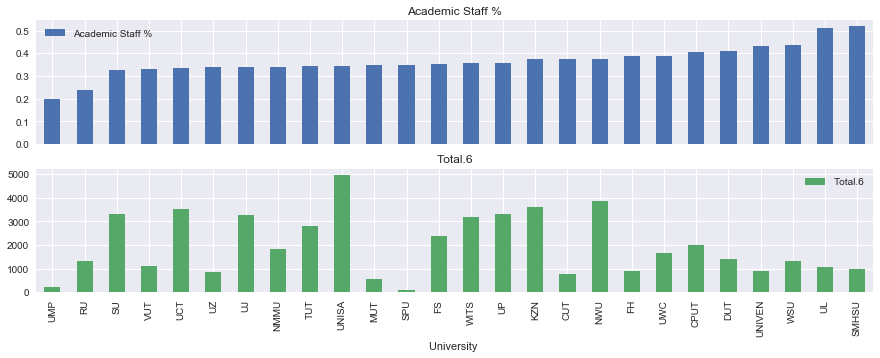

In [288]:
# I don't use this data  in the final analysis, but it is interesting to look at the academic 
# to total staff ratio
data = pandas.read_excel(staff_types_spreadsheet, skiprows=8, index_col=0)
data = data[1:-1]
data.index = data.index.str.strip()
academic_staff = data.loc[:,['Academic.6']]
support_staff = data.loc[:,['Total.6']].values - data.loc[:,['Academic.6']].values
total_staff = data.loc[:,['Total.6']]
academic_staff_ratio = pandas.Series(data=(
    academic_staff.values / total_staff.values).squeeze(), index=data.index, name='Academic Staff %')
academic_staff_ratio_data = pandas.concat(
    [data, academic_staff_ratio], axis=1).loc[:,['University ', 
                                                 'University Name ', 'Academic Staff %', 'Total.6']]
academic_staff_ratio_data.index = academic_staff_ratio_data.loc[:,'University ']
academic_staff_ratio_data = academic_staff_ratio_data.drop('University ', axis=1)
academic_staff_ratio_data.sort_values(
    'Academic Staff %').loc[:,['Academic Staff %', 'Total.6']].plot(kind='bar',
                                                                    subplots=True,
                                                                    figsize=(15,5))
